# Using GANs on Fashion MNIST

In [0]:
!mkdir images

### Import Libraries

In [0]:
from __future__ import print_function, division
import tensorflow as tf

from tensorflow.python.keras.datasets import fashion_mnist
from tensorflow.python.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np


### Function for image visualisation

In [0]:
def sample_images(gen_imgs,img_name):
    r, c = 5, 5
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/{}.png".format(img_name))
    plt.show()
    plt.close()

### Download the dataset from the keras function

In [0]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)


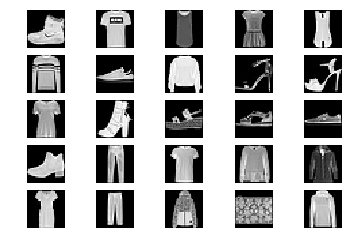

In [14]:
sample_images(X_train,"train_images")

### DCGAN model

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)


In [0]:
def train(gan,gan_noise, epochs, batch_size=128, sample_interval=50):
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))

        gen_imgs = gan.generator.predict(noise)

        # Train the discriminator
        d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
        d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = gan.combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            
            gen_imgs = gan.generator.predict(gan_noise)
            sample_images(gen_imgs,100000+epoch)

   



### Train GANs

In [0]:
gan = GAN()
r, c = 5, 5
gan_noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
train(gan,gan_noise, epochs=10000, batch_size=128, sample_interval=50)

## Final result

**At epoch 0**

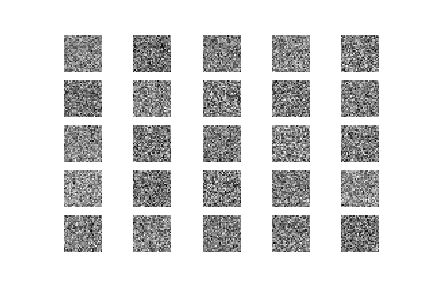

In [22]:
 Image(filename='images/100000.png')

**At epoch 2500**

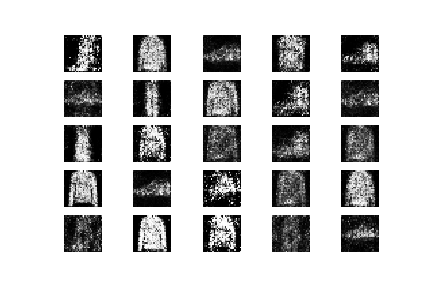

In [23]:
Image(filename='images/102500.png')

**At epoch 5000**

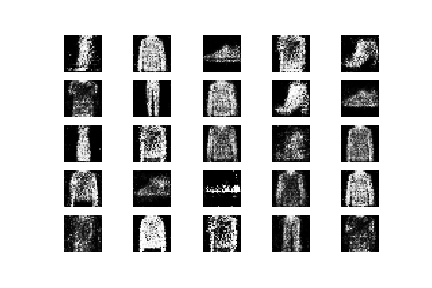

In [24]:
Image(filename='images/105000.png')

**At epoch 7500**

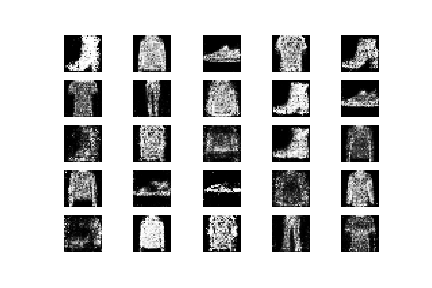

In [25]:
Image(filename='images/107500.png')

**At epoch 10000**

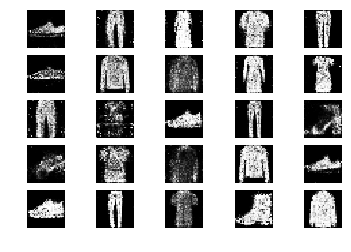

In [16]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)
sample_images(gen_imgs,100000+10000)